In [1]:
# Import
import os
from PIL import Image

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-01-14 10:00:02.059170: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 10:00:02.090727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-14 10:00:02.090756: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-14 10:00:02.090776: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 10:00:02.096770: I tensorflow/core/platform/cpu_feature_g

# Training (Nitrate)

In [2]:
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/related_sulfate_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17], ctrl_data[:, 17]
# -------------
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Sulfate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [3]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/sulfate/modified/pm25/final_model'  # 모델 저장 경로

epochs = 500  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*1,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=5,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )
    
# define callback
def scheduler(epoch, lr):
    if epoch < 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-01-14 10:00:04.431578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21698 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-01-14 10:00:04.433231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21700 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-01-14 10:00:04.434764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 21700 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-01-14 10:00:04.436271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21576 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-01-14 10:00:31.695455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-14 10:00:31.718255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-14 10:00:31.733777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-14 10:00:31.743677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-14 10:00:34.293330: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3e774f8a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-14 10:00:34.293361: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-14 10:00:34.293365: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-14 10:00:34.29336

3/3 [==============================] - ETA: 0s - loss: 5.0372 INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-01-7.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-01-7.68/assets


3/3 [==============================] - 47s 7s/step - loss: 5.0372 - val_loss: 7.6781 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - ETA: 0s - loss: 3.4243INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-02-7.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-02-7.53/assets


3/3 [==============================] - 9s 5s/step - loss: 3.4243 - val_loss: 7.5281 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - ETA: 0s - loss: 2.3987INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-03-7.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-03-7.34/assets


3/3 [==============================] - 10s 5s/step - loss: 2.3987 - val_loss: 7.3364 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - ETA: 0s - loss: 1.7497INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-04-7.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-04-7.13/assets


3/3 [==============================] - 10s 5s/step - loss: 1.7497 - val_loss: 7.1326 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - ETA: 0s - loss: 1.4012INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-05-6.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-05-6.94/assets


3/3 [==============================] - 9s 5s/step - loss: 1.4012 - val_loss: 6.9355 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - ETA: 0s - loss: 1.1895INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-06-6.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-06-6.74/assets


3/3 [==============================] - 10s 5s/step - loss: 1.1895 - val_loss: 6.7389 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - ETA: 0s - loss: 1.0231INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-07-6.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-07-6.54/assets


3/3 [==============================] - 10s 5s/step - loss: 1.0231 - val_loss: 6.5397 - lr: 0.0010
Epoch 8/500
3/3 [==============================] - ETA: 0s - loss: 0.8964INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-08-6.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-08-6.35/assets


3/3 [==============================] - 10s 5s/step - loss: 0.8964 - val_loss: 6.3484 - lr: 0.0010
Epoch 9/500
3/3 [==============================] - ETA: 0s - loss: 0.7976INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-09-6.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-09-6.17/assets


3/3 [==============================] - 10s 5s/step - loss: 0.7976 - val_loss: 6.1700 - lr: 0.0010
Epoch 10/500
3/3 [==============================] - ETA: 0s - loss: 0.7079INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-10-6.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-10-6.00/assets


3/3 [==============================] - 10s 5s/step - loss: 0.7079 - val_loss: 6.0044 - lr: 0.0010
Epoch 11/500
3/3 [==============================] - ETA: 0s - loss: 0.6356INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-11-5.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-11-5.84/assets


3/3 [==============================] - 10s 5s/step - loss: 0.6356 - val_loss: 5.8408 - lr: 0.0010
Epoch 12/500
3/3 [==============================] - ETA: 0s - loss: 0.5677INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-12-5.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-12-5.68/assets


3/3 [==============================] - 10s 5s/step - loss: 0.5677 - val_loss: 5.6845 - lr: 0.0010
Epoch 13/500
2/3 [===================>..........] - ETA: 0s - loss: 0.5150INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-13-5.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-13-5.54/assets


3/3 [==============================] - 10s 5s/step - loss: 0.5123 - val_loss: 5.5439 - lr: 0.0010
Epoch 14/500
3/3 [==============================] - ETA: 0s - loss: 0.4622INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-14-5.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-14-5.41/assets


3/3 [==============================] - 10s 5s/step - loss: 0.4622 - val_loss: 5.4127 - lr: 0.0010
Epoch 15/500
3/3 [==============================] - ETA: 0s - loss: 0.4209INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-15-5.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-15-5.28/assets


3/3 [==============================] - 10s 5s/step - loss: 0.4209 - val_loss: 5.2761 - lr: 0.0010
Epoch 16/500
3/3 [==============================] - ETA: 0s - loss: 0.3819INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-16-5.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-16-5.14/assets


3/3 [==============================] - 10s 5s/step - loss: 0.3819 - val_loss: 5.1407 - lr: 0.0010
Epoch 17/500
3/3 [==============================] - ETA: 0s - loss: 0.3490INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-17-5.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-17-5.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.3490 - val_loss: 5.0266 - lr: 0.0010
Epoch 18/500
3/3 [==============================] - ETA: 0s - loss: 0.3188INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-18-4.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-18-4.92/assets


3/3 [==============================] - 11s 6s/step - loss: 0.3188 - val_loss: 4.9234 - lr: 0.0010
Epoch 19/500
3/3 [==============================] - ETA: 0s - loss: 0.2939INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-19-4.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-19-4.81/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2939 - val_loss: 4.8097 - lr: 0.0010
Epoch 20/500
2/3 [===================>..........] - ETA: 0s - loss: 0.2717INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-20-4.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-20-4.70/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2705 - val_loss: 4.7005 - lr: 0.0010
Epoch 21/500
3/3 [==============================] - ETA: 0s - loss: 0.2494INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-21-4.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-21-4.60/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2494 - val_loss: 4.5999 - lr: 0.0010
Epoch 22/500
2/3 [===================>..........] - ETA: 0s - loss: 0.2321INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-22-4.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-22-4.50/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2311 - val_loss: 4.5010 - lr: 0.0010
Epoch 23/500
3/3 [==============================] - ETA: 0s - loss: 0.2146INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-23-4.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-23-4.41/assets


3/3 [==============================] - 11s 5s/step - loss: 0.2146 - val_loss: 4.4093 - lr: 0.0010
Epoch 24/500
2/3 [===================>..........] - ETA: 0s - loss: 0.2001INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-24-4.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-24-4.32/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1992 - val_loss: 4.3210 - lr: 0.0010
Epoch 25/500
3/3 [==============================] - ETA: 0s - loss: 0.1862INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-25-4.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-25-4.24/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1862 - val_loss: 4.2388 - lr: 0.0010
Epoch 26/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1748INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-26-4.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-26-4.16/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1741 - val_loss: 4.1632 - lr: 0.0010
Epoch 27/500
3/3 [==============================] - ETA: 0s - loss: 0.1624INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-27-4.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-27-4.09/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1624 - val_loss: 4.0914 - lr: 0.0010
Epoch 28/500
3/3 [==============================] - ETA: 0s - loss: 0.1529INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-28-4.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-28-4.03/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1529 - val_loss: 4.0268 - lr: 0.0010
Epoch 29/500
3/3 [==============================] - ETA: 0s - loss: 0.1436INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-29-3.97/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-29-3.97/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1436 - val_loss: 3.9679 - lr: 0.0010
Epoch 30/500
3/3 [==============================] - ETA: 0s - loss: 0.1350INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-30-3.90/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-30-3.90/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1350 - val_loss: 3.9044 - lr: 0.0010
Epoch 31/500
3/3 [==============================] - ETA: 0s - loss: 0.1265INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-31-3.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-31-3.85/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1265 - val_loss: 3.8528 - lr: 0.0010
Epoch 32/500
3/3 [==============================] - ETA: 0s - loss: 0.1193INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-32-3.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-32-3.80/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1193 - val_loss: 3.8014 - lr: 0.0010
Epoch 33/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1127INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-33-3.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-33-3.75/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1127 - val_loss: 3.7456 - lr: 0.0010
Epoch 34/500
3/3 [==============================] - ETA: 0s - loss: 0.1063INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-34-3.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-34-3.70/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1063 - val_loss: 3.7007 - lr: 0.0010
Epoch 35/500
3/3 [==============================] - ETA: 0s - loss: 0.1005INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-35-3.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-35-3.65/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1005 - val_loss: 3.6476 - lr: 0.0010
Epoch 36/500
3/3 [==============================] - ETA: 0s - loss: 0.0948INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-36-3.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-36-3.61/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0948 - val_loss: 3.6108 - lr: 0.0010
Epoch 37/500
3/3 [==============================] - ETA: 0s - loss: 0.0897INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-37-3.56/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-37-3.56/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0897 - val_loss: 3.5586 - lr: 0.0010
Epoch 38/500
3/3 [==============================] - ETA: 0s - loss: 0.0852INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-38-3.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-38-3.53/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0852 - val_loss: 3.5297 - lr: 0.0010
Epoch 39/500
3/3 [==============================] - ETA: 0s - loss: 0.0809INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-39-3.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-39-3.49/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0809 - val_loss: 3.4861 - lr: 0.0010
Epoch 40/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0775INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-40-3.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-40-3.45/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0774 - val_loss: 3.4518 - lr: 0.0010
Epoch 41/500
3/3 [==============================] - ETA: 0s - loss: 0.0739INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-41-3.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-41-3.41/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0739 - val_loss: 3.4119 - lr: 0.0010
Epoch 42/500
3/3 [==============================] - ETA: 0s - loss: 0.0707INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-42-3.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-42-3.37/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0707 - val_loss: 3.3727 - lr: 0.0010
Epoch 43/500
3/3 [==============================] - ETA: 0s - loss: 0.0676INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-43-3.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-43-3.35/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0676 - val_loss: 3.3507 - lr: 0.0010
Epoch 44/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0646INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-44-3.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-44-3.31/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0645 - val_loss: 3.3103 - lr: 0.0010
Epoch 45/500
3/3 [==============================] - ETA: 0s - loss: 0.0618INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-45-3.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-45-3.29/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0618 - val_loss: 3.2857 - lr: 0.0010
Epoch 46/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0597INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-46-3.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-46-3.25/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0596 - val_loss: 3.2533 - lr: 0.0010
Epoch 47/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0593INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-47-3.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-47-3.23/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0592 - val_loss: 3.2264 - lr: 0.0010
Epoch 48/500
3/3 [==============================] - ETA: 0s - loss: 0.0557INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-48-3.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-48-3.20/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0557 - val_loss: 3.1964 - lr: 0.0010
Epoch 49/500
3/3 [==============================] - ETA: 0s - loss: 0.0544INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-49-3.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-49-3.17/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0544 - val_loss: 3.1746 - lr: 0.0010
Epoch 50/500
3/3 [==============================] - ETA: 0s - loss: 0.0535INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-50-3.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-50-3.16/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0535 - val_loss: 3.1569 - lr: 0.0010
Epoch 51/500
3/3 [==============================] - ETA: 0s - loss: 0.0509INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-51-3.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-51-3.13/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0509 - val_loss: 3.1253 - lr: 0.0010
Epoch 52/500
3/3 [==============================] - ETA: 0s - loss: 0.0492INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-52-3.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-52-3.10/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0492 - val_loss: 3.0989 - lr: 0.0010
Epoch 53/500
3/3 [==============================] - ETA: 0s - loss: 0.0481INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-53-3.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-53-3.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0481 - val_loss: 3.0895 - lr: 0.0010
Epoch 54/500
3/3 [==============================] - ETA: 0s - loss: 0.0471INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-54-3.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-54-3.06/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0471 - val_loss: 3.0610 - lr: 0.0010
Epoch 55/500
3/3 [==============================] - ETA: 0s - loss: 0.0467INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-55-3.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-55-3.04/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0467 - val_loss: 3.0427 - lr: 0.0010
Epoch 56/500
3/3 [==============================] - ETA: 0s - loss: 0.0455INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-56-3.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-56-3.03/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0455 - val_loss: 3.0253 - lr: 0.0010
Epoch 57/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0445INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-57-3.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-57-3.01/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0444 - val_loss: 3.0075 - lr: 0.0010
Epoch 58/500
3/3 [==============================] - ETA: 0s - loss: 0.0440INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-58-2.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-58-2.98/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0440 - val_loss: 2.9772 - lr: 0.0010
Epoch 59/500
3/3 [==============================] - ETA: 0s - loss: 0.0434INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-59-2.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-59-2.96/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0434 - val_loss: 2.9605 - lr: 0.0010
Epoch 60/500
3/3 [==============================] - ETA: 0s - loss: 0.0422INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-60-2.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-60-2.95/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0422 - val_loss: 2.9499 - lr: 0.0010
Epoch 61/500
3/3 [==============================] - ETA: 0s - loss: 0.0418INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-61-2.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-61-2.93/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0418 - val_loss: 2.9315 - lr: 0.0010
Epoch 62/500
3/3 [==============================] - ETA: 0s - loss: 0.0428INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-62-2.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-62-2.91/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0428 - val_loss: 2.9150 - lr: 0.0010
Epoch 63/500
3/3 [==============================] - ETA: 0s - loss: 0.0412INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-63-2.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-63-2.89/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0412 - val_loss: 2.8893 - lr: 0.0010
Epoch 64/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0401INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-64-2.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-64-2.88/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0401 - val_loss: 2.8810 - lr: 0.0010
Epoch 65/500
3/3 [==============================] - ETA: 0s - loss: 0.0398INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-65-2.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-65-2.86/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0398 - val_loss: 2.8638 - lr: 0.0010
Epoch 66/500
3/3 [==============================] - ETA: 0s - loss: 0.0396INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-66-2.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-66-2.84/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0396 - val_loss: 2.8387 - lr: 0.0010
Epoch 67/500
3/3 [==============================] - ETA: 0s - loss: 0.0397INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-67-2.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-67-2.82/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0397 - val_loss: 2.8241 - lr: 0.0010
Epoch 68/500
3/3 [==============================] - ETA: 0s - loss: 0.0395INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-68-2.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-68-2.80/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0395 - val_loss: 2.8009 - lr: 0.0010
Epoch 69/500
3/3 [==============================] - ETA: 0s - loss: 0.0385INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-69-2.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-69-2.80/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0385 - val_loss: 2.7955 - lr: 0.0010
Epoch 70/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0384INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-70-2.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-70-2.76/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0384 - val_loss: 2.7643 - lr: 0.0010
Epoch 71/500
3/3 [==============================] - ETA: 0s - loss: 0.0380INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-71-2.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-71-2.75/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0380 - val_loss: 2.7511 - lr: 0.0010
Epoch 72/500
3/3 [==============================] - ETA: 0s - loss: 0.0378INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-72-2.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-72-2.74/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0378 - val_loss: 2.7369 - lr: 0.0010
Epoch 73/500
3/3 [==============================] - ETA: 0s - loss: 0.0375INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-73-2.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-73-2.72/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0375 - val_loss: 2.7181 - lr: 0.0010
Epoch 74/500
3/3 [==============================] - ETA: 0s - loss: 0.0371INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-74-2.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-74-2.69/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0371 - val_loss: 2.6928 - lr: 0.0010
Epoch 75/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0371INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-75-2.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-75-2.69/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0371 - val_loss: 2.6882 - lr: 0.0010
Epoch 76/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0370INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-76-2.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-76-2.67/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0369 - val_loss: 2.6682 - lr: 0.0010
Epoch 77/500
3/3 [==============================] - ETA: 0s - loss: 0.0369INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-77-2.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-77-2.64/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0369 - val_loss: 2.6381 - lr: 0.0010
Epoch 78/500
3/3 [==============================] - ETA: 0s - loss: 0.0365INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-78-2.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-78-2.64/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0365 - val_loss: 2.6366 - lr: 0.0010
Epoch 79/500
3/3 [==============================] - ETA: 0s - loss: 0.0363INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-79-2.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-79-2.61/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0363 - val_loss: 2.6123 - lr: 0.0010
Epoch 80/500
3/3 [==============================] - ETA: 0s - loss: 0.0361INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-80-2.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-80-2.59/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0361 - val_loss: 2.5924 - lr: 0.0010
Epoch 81/500
3/3 [==============================] - ETA: 0s - loss: 0.0361INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-81-2.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-81-2.58/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0361 - val_loss: 2.5819 - lr: 0.0010
Epoch 82/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0359INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-82-2.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-82-2.54/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0359 - val_loss: 2.5387 - lr: 0.0010
Epoch 83/500
3/3 [==============================] - ETA: 0s - loss: 0.0360INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-83-2.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-83-2.53/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0360 - val_loss: 2.5300 - lr: 0.0010
Epoch 84/500
3/3 [==============================] - ETA: 0s - loss: 0.0357INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-84-2.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-84-2.50/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0357 - val_loss: 2.5030 - lr: 0.0010
Epoch 85/500
3/3 [==============================] - ETA: 0s - loss: 0.0352INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-85-2.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-85-2.49/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0352 - val_loss: 2.4900 - lr: 0.0010
Epoch 86/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0351INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-86-2.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-86-2.46/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0351 - val_loss: 2.4600 - lr: 0.0010
Epoch 87/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0352INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-87-2.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-87-2.43/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0352 - val_loss: 2.4273 - lr: 0.0010
Epoch 88/500
3/3 [==============================] - ETA: 0s - loss: 0.0349INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-88-2.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-88-2.42/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0349 - val_loss: 2.4155 - lr: 0.0010
Epoch 89/500
3/3 [==============================] - ETA: 0s - loss: 0.0348INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-89-2.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-89-2.39/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0348 - val_loss: 2.3907 - lr: 0.0010
Epoch 90/500
3/3 [==============================] - ETA: 0s - loss: 0.0348INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-90-2.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-90-2.36/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0348 - val_loss: 2.3565 - lr: 0.0010
Epoch 91/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0349INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-91-2.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-91-2.33/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0349 - val_loss: 2.3284 - lr: 0.0010
Epoch 92/500
3/3 [==============================] - ETA: 0s - loss: 0.0349INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-92-2.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-92-2.30/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0349 - val_loss: 2.3039 - lr: 0.0010
Epoch 93/500
3/3 [==============================] - ETA: 0s - loss: 0.0346INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-93-2.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-93-2.28/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0346 - val_loss: 2.2786 - lr: 0.0010
Epoch 94/500
3/3 [==============================] - ETA: 0s - loss: 0.0347INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-94-2.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-94-2.25/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0347 - val_loss: 2.2466 - lr: 0.0010
Epoch 95/500
3/3 [==============================] - ETA: 0s - loss: 0.0348INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-95-2.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-95-2.22/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0348 - val_loss: 2.2233 - lr: 0.0010
Epoch 96/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0344INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-96-2.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-96-2.19/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0343 - val_loss: 2.1872 - lr: 0.0010
Epoch 97/500
3/3 [==============================] - ETA: 0s - loss: 0.0343INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-97-2.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-97-2.16/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0343 - val_loss: 2.1623 - lr: 0.0010
Epoch 98/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0343INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-98-2.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-98-2.12/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0343 - val_loss: 2.1247 - lr: 0.0010
Epoch 99/500
3/3 [==============================] - ETA: 0s - loss: 0.0342INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-99-2.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-99-2.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0342 - val_loss: 2.0964 - lr: 0.0010
Epoch 100/500
3/3 [==============================] - ETA: 0s - loss: 0.0343INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-100-2.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-100-2.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0343 - val_loss: 2.0723 - lr: 0.0010
Epoch 101/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0344INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-101-2.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-101-2.03/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0344 - val_loss: 2.0270 - lr: 0.0010
Epoch 102/500
3/3 [==============================] - ETA: 0s - loss: 0.0342INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-102-2.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-102-2.00/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0342 - val_loss: 1.9971 - lr: 0.0010
Epoch 103/500
3/3 [==============================] - ETA: 0s - loss: 0.0341INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-103-1.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-103-1.96/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0341 - val_loss: 1.9608 - lr: 0.0010
Epoch 104/500
3/3 [==============================] - ETA: 0s - loss: 0.0341INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-104-1.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-104-1.92/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0341 - val_loss: 1.9224 - lr: 0.0010
Epoch 105/500
3/3 [==============================] - ETA: 0s - loss: 0.0340INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-105-1.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-105-1.89/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0340 - val_loss: 1.8861 - lr: 0.0010
Epoch 106/500
3/3 [==============================] - ETA: 0s - loss: 0.0341INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-106-1.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-106-1.84/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0341 - val_loss: 1.8357 - lr: 0.0010
Epoch 107/500
3/3 [==============================] - ETA: 0s - loss: 0.0341INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-107-1.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-107-1.80/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0341 - val_loss: 1.8027 - lr: 0.0010
Epoch 108/500
3/3 [==============================] - ETA: 0s - loss: 0.0339INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-108-1.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-108-1.76/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0339 - val_loss: 1.7607 - lr: 0.0010
Epoch 109/500
3/3 [==============================] - ETA: 0s - loss: 0.0339INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-109-1.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-109-1.72/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0339 - val_loss: 1.7174 - lr: 0.0010
Epoch 110/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0339INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-110-1.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-110-1.69/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0339 - val_loss: 1.6871 - lr: 0.0010
Epoch 111/500
3/3 [==============================] - ETA: 0s - loss: 0.0338INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-111-1.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-111-1.65/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0338 - val_loss: 1.6465 - lr: 0.0010
Epoch 112/500
3/3 [==============================] - ETA: 0s - loss: 0.0339INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-112-1.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-112-1.61/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0339 - val_loss: 1.6075 - lr: 0.0010
Epoch 113/500
3/3 [==============================] - ETA: 0s - loss: 0.0338INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-113-1.56/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-113-1.56/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0338 - val_loss: 1.5594 - lr: 0.0010
Epoch 114/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0337INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-114-1.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-114-1.51/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0337 - val_loss: 1.5126 - lr: 0.0010
Epoch 115/500
3/3 [==============================] - ETA: 0s - loss: 0.0337INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-115-1.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-115-1.48/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0337 - val_loss: 1.4754 - lr: 0.0010
Epoch 116/500
3/3 [==============================] - ETA: 0s - loss: 0.0336INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-116-1.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-116-1.43/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0336 - val_loss: 1.4305 - lr: 0.0010
Epoch 117/500
3/3 [==============================] - ETA: 0s - loss: 0.0336INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-117-1.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-117-1.39/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0336 - val_loss: 1.3891 - lr: 0.0010
Epoch 118/500
3/3 [==============================] - ETA: 0s - loss: 0.0336INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-118-1.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-118-1.34/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0336 - val_loss: 1.3446 - lr: 0.0010
Epoch 119/500
3/3 [==============================] - ETA: 0s - loss: 0.0334INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-119-1.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-119-1.31/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0334 - val_loss: 1.3076 - lr: 0.0010
Epoch 120/500
3/3 [==============================] - ETA: 0s - loss: 0.0334INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-120-1.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-120-1.26/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0334 - val_loss: 1.2605 - lr: 0.0010
Epoch 121/500
3/3 [==============================] - ETA: 0s - loss: 0.0336INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-121-1.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-121-1.22/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0336 - val_loss: 1.2184 - lr: 0.0010
Epoch 122/500
3/3 [==============================] - ETA: 0s - loss: 0.0335INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-122-1.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-122-1.18/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0335 - val_loss: 1.1841 - lr: 0.0010
Epoch 123/500
3/3 [==============================] - ETA: 0s - loss: 0.0337INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-123-1.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-123-1.14/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0337 - val_loss: 1.1370 - lr: 0.0010
Epoch 124/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0342INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-124-1.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-124-1.10/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0341 - val_loss: 1.0985 - lr: 0.0010
Epoch 125/500
3/3 [==============================] - ETA: 0s - loss: 0.0340INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-125-1.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-125-1.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0340 - val_loss: 1.0551 - lr: 0.0010
Epoch 126/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0343INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-126-1.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-126-1.01/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0342 - val_loss: 1.0137 - lr: 0.0010
Epoch 127/500
3/3 [==============================] - ETA: 0s - loss: 0.0337INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-127-0.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-127-0.98/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0337 - val_loss: 0.9768 - lr: 0.0010
Epoch 128/500
3/3 [==============================] - ETA: 0s - loss: 0.0334INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-128-0.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-128-0.94/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0334 - val_loss: 0.9360 - lr: 0.0010
Epoch 129/500
3/3 [==============================] - ETA: 0s - loss: 0.0332INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-129-0.90/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-129-0.90/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0332 - val_loss: 0.8991 - lr: 0.0010
Epoch 130/500
3/3 [==============================] - ETA: 0s - loss: 0.0334INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-130-0.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-130-0.86/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0334 - val_loss: 0.8623 - lr: 0.0010
Epoch 131/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0332INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-131-0.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-131-0.82/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0333 - val_loss: 0.8240 - lr: 0.0010
Epoch 132/500
3/3 [==============================] - ETA: 0s - loss: 0.0333INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-132-0.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-132-0.79/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0333 - val_loss: 0.7887 - lr: 0.0010
Epoch 133/500
3/3 [==============================] - ETA: 0s - loss: 0.0332INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-133-0.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-133-0.76/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0332 - val_loss: 0.7573 - lr: 0.0010
Epoch 134/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0336INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-134-0.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-134-0.73/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0335 - val_loss: 0.7293 - lr: 0.0010
Epoch 135/500
3/3 [==============================] - ETA: 0s - loss: 0.0335INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-135-0.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-135-0.69/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0335 - val_loss: 0.6856 - lr: 0.0010
Epoch 136/500
3/3 [==============================] - ETA: 0s - loss: 0.0333INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-136-0.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-136-0.66/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0333 - val_loss: 0.6607 - lr: 0.0010
Epoch 137/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0334INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-137-0.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-137-0.62/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0334 - val_loss: 0.6248 - lr: 0.0010
Epoch 138/500
3/3 [==============================] - ETA: 0s - loss: 0.0331INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-138-0.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-138-0.60/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0331 - val_loss: 0.5962 - lr: 0.0010
Epoch 139/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0331INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-139-0.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-139-0.57/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0331 - val_loss: 0.5700 - lr: 0.0010
Epoch 140/500
3/3 [==============================] - ETA: 0s - loss: 0.0331INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-140-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-140-0.53/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0331 - val_loss: 0.5350 - lr: 0.0010
Epoch 141/500
3/3 [==============================] - ETA: 0s - loss: 0.0332INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-141-0.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-141-0.51/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0332 - val_loss: 0.5150 - lr: 0.0010
Epoch 142/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0330INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-142-0.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-142-0.49/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0330 - val_loss: 0.4894 - lr: 0.0010
Epoch 143/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0329INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-143-0.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-143-0.46/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0330 - val_loss: 0.4628 - lr: 0.0010
Epoch 144/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0330INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-144-0.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-144-0.44/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0330 - val_loss: 0.4368 - lr: 0.0010
Epoch 145/500
3/3 [==============================] - ETA: 0s - loss: 0.0330INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-145-0.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-145-0.41/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0330 - val_loss: 0.4141 - lr: 0.0010
Epoch 146/500
3/3 [==============================] - ETA: 0s - loss: 0.0330INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-146-0.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-146-0.39/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0330 - val_loss: 0.3934 - lr: 0.0010
Epoch 147/500
3/3 [==============================] - ETA: 0s - loss: 0.0329INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-147-0.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-147-0.38/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0329 - val_loss: 0.3764 - lr: 0.0010
Epoch 148/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0331INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-148-0.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-148-0.36/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0331 - val_loss: 0.3586 - lr: 0.0010
Epoch 149/500
3/3 [==============================] - ETA: 0s - loss: 0.0330INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-149-0.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-149-0.34/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0330 - val_loss: 0.3361 - lr: 0.0010
Epoch 150/500
3/3 [==============================] - ETA: 0s - loss: 0.0332INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-150-0.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-150-0.32/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0332 - val_loss: 0.3194 - lr: 0.0010
Epoch 151/500
3/3 [==============================] - ETA: 0s - loss: 0.0329INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-151-0.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-151-0.31/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0329 - val_loss: 0.3109 - lr: 0.0010
Epoch 152/500
3/3 [==============================] - ETA: 0s - loss: 0.0330INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-152-0.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-152-0.29/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0330 - val_loss: 0.2905 - lr: 0.0010
Epoch 153/500
3/3 [==============================] - ETA: 0s - loss: 0.0329INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-153-0.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-153-0.27/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0329 - val_loss: 0.2731 - lr: 0.0010
Epoch 154/500
3/3 [==============================] - ETA: 0s - loss: 0.0329INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-154-0.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-154-0.26/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0329 - val_loss: 0.2575 - lr: 0.0010
Epoch 155/500
3/3 [==============================] - ETA: 0s - loss: 0.0331INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-155-0.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-155-0.25/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0331 - val_loss: 0.2521 - lr: 0.0010
Epoch 156/500
3/3 [==============================] - ETA: 0s - loss: 0.0330INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-156-0.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-156-0.23/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0330 - val_loss: 0.2311 - lr: 0.0010
Epoch 157/500
3/3 [==============================] - ETA: 0s - loss: 0.0329INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-157-0.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-157-0.22/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0329 - val_loss: 0.2196 - lr: 0.0010
Epoch 158/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0330INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-158-0.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-158-0.21/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0330 - val_loss: 0.2074 - lr: 0.0010
Epoch 159/500
3/3 [==============================] - ETA: 0s - loss: 0.0329INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-159-0.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-159-0.20/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0329 - val_loss: 0.1951 - lr: 0.0010
Epoch 160/500
3/3 [==============================] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-160-0.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-160-0.18/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0328 - val_loss: 0.1821 - lr: 0.0010
Epoch 161/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-161-0.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-161-0.17/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0328 - val_loss: 0.1744 - lr: 0.0010
Epoch 162/500
3/3 [==============================] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-162-0.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-162-0.17/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0328 - val_loss: 0.1662 - lr: 0.0010
Epoch 163/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0329INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-163-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-163-0.15/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0329 - val_loss: 0.1537 - lr: 0.0010
Epoch 164/500
3/3 [==============================] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-164-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-164-0.15/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0328 - val_loss: 0.1463 - lr: 0.0010
Epoch 165/500
3/3 [==============================] - ETA: 0s - loss: 0.0329INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-165-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-165-0.14/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0329 - val_loss: 0.1425 - lr: 0.0010
Epoch 166/500
3/3 [==============================] - ETA: 0s - loss: 0.0329INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-166-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-166-0.14/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0329 - val_loss: 0.1391 - lr: 0.0010
Epoch 167/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-167-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-167-0.13/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0328 - val_loss: 0.1283 - lr: 0.0010
Epoch 168/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-168-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-168-0.12/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0329 - val_loss: 0.1209 - lr: 0.0010
Epoch 169/500
3/3 [==============================] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-169-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-169-0.12/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0328 - val_loss: 0.1174 - lr: 0.0010
Epoch 170/500
3/3 [==============================] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-170-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-170-0.11/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0328 - val_loss: 0.1097 - lr: 0.0010
Epoch 171/500
3/3 [==============================] - ETA: 0s - loss: 0.0327INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-171-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-171-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0327 - val_loss: 0.1029 - lr: 0.0010
Epoch 172/500
3/3 [==============================] - ETA: 0s - loss: 0.0327INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-172-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-172-0.10/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0327 - val_loss: 0.0981 - lr: 0.0010
Epoch 173/500
3/3 [==============================] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-173-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-173-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0326 - val_loss: 0.0955 - lr: 0.0010
Epoch 174/500
3/3 [==============================] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-174-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-174-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0326 - val_loss: 0.0901 - lr: 0.0010
Epoch 175/500
3/3 [==============================] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-175-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-175-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0326 - val_loss: 0.0870 - lr: 0.0010
Epoch 176/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-176-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-176-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0326 - val_loss: 0.0809 - lr: 0.0010
Epoch 177/500
3/3 [==============================] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-177-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-177-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0328 - val_loss: 0.0788 - lr: 0.0010
Epoch 178/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-178-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-178-0.08/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0326 - val_loss: 0.0778 - lr: 0.0010
Epoch 179/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-179-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-179-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0326 - val_loss: 0.0731 - lr: 0.0010
Epoch 180/500
3/3 [==============================] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-180-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-180-0.07/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0326 - val_loss: 0.0698 - lr: 0.0010
Epoch 181/500
3/3 [==============================] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-181-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-181-0.07/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0326 - val_loss: 0.0674 - lr: 0.0010
Epoch 182/500
3/3 [==============================] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-182-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-182-0.06/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0326 - val_loss: 0.0646 - lr: 0.0010
Epoch 183/500
3/3 [==============================] - ETA: 0s - loss: 0.0327INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-183-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-183-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0327 - val_loss: 0.0616 - lr: 0.0010
Epoch 184/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-184-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-184-0.06/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0326 - val_loss: 0.0606 - lr: 0.0010
Epoch 185/500
3/3 [==============================] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-185-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-185-0.06/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0328 - val_loss: 0.0576 - lr: 0.0010
Epoch 186/500
3/3 [==============================] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-186-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-186-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0326 - val_loss: 0.0558 - lr: 0.0010
Epoch 187/500
3/3 [==============================] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-187-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-187-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0325 - val_loss: 0.0533 - lr: 0.0010
Epoch 188/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-188-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-188-0.05/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0325 - val_loss: 0.0526 - lr: 0.0010
Epoch 189/500
3/3 [==============================] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-189-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-189-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0325 - val_loss: 0.0509 - lr: 0.0010
Epoch 190/500
3/3 [==============================] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-190-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-190-0.05/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0325 - val_loss: 0.0499 - lr: 0.0010
Epoch 191/500
3/3 [==============================] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-191-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-191-0.05/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0325 - val_loss: 0.0472 - lr: 0.0010
Epoch 192/500
3/3 [==============================] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-192-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-192-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0325 - val_loss: 0.0470 - lr: 0.0010
Epoch 193/500
3/3 [==============================] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-193-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-193-0.05/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0326 - val_loss: 0.0462 - lr: 0.0010
Epoch 194/500
3/3 [==============================] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-194-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-194-0.05/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0325 - val_loss: 0.0452 - lr: 0.0010
Epoch 195/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-195-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-195-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0325 - val_loss: 0.0444 - lr: 0.0010
Epoch 196/500
3/3 [==============================] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-196-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-196-0.04/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0325 - val_loss: 0.0428 - lr: 0.0010
Epoch 197/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-197-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-197-0.04/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0326 - val_loss: 0.0422 - lr: 0.0010
Epoch 198/500
3/3 [==============================] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-198-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-198-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0328 - val_loss: 0.0402 - lr: 0.0010
Epoch 199/500
3/3 [==============================] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-199-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-199-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0328 - val_loss: 0.0396 - lr: 0.0010
Epoch 200/500
3/3 [==============================] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-200-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-200-0.04/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0326 - val_loss: 0.0388 - lr: 0.0010
Epoch 201/500
3/3 [==============================] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-201-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-201-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0325 - val_loss: 0.0385 - lr: 0.0010
Epoch 202/500
3/3 [==============================] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-202-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-202-0.04/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0325 - val_loss: 0.0376 - lr: 0.0010
Epoch 203/500
3/3 [==============================] - ETA: 0s - loss: 0.0324INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-203-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-203-0.04/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0324 - val_loss: 0.0375 - lr: 0.0010
Epoch 204/500
3/3 [==============================] - ETA: 0s - loss: 0.0324INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-204-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-204-0.04/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0324 - val_loss: 0.0370 - lr: 0.0010
Epoch 205/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-205-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-205-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0324 - val_loss: 0.0365 - lr: 0.0010
Epoch 206/500
3/3 [==============================] - ETA: 0s - loss: 0.0324INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-206-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-206-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0324 - val_loss: 0.0361 - lr: 0.0010
Epoch 207/500
3/3 [==============================] - ETA: 0s - loss: 0.0324INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-207-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-207-0.04/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0324 - val_loss: 0.0356 - lr: 0.0010
Epoch 208/500
3/3 [==============================] - ETA: 0s - loss: 0.0324INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-208-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-208-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0324 - val_loss: 0.0354 - lr: 0.0010
Epoch 209/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0324 - val_loss: 0.0359 - lr: 0.0010
Epoch 210/500
3/3 [==============================] - ETA: 0s - loss: 0.0324INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-210-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-210-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0324 - val_loss: 0.0351 - lr: 0.0010
Epoch 211/500
3/3 [==============================] - ETA: 0s - loss: 0.0324INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-211-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-211-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0324 - val_loss: 0.0347 - lr: 0.0010
Epoch 212/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-212-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-212-0.03/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0323 - val_loss: 0.0343 - lr: 0.0010
Epoch 213/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0323 - val_loss: 0.0347 - lr: 0.0010
Epoch 214/500
3/3 [==============================] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-214-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-214-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0323 - val_loss: 0.0340 - lr: 0.0010
Epoch 215/500
3/3 [==============================] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-215-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-215-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0323 - val_loss: 0.0340 - lr: 0.0010
Epoch 216/500
3/3 [==============================] - ETA: 0s - loss: 0.0324INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-216-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-216-0.03/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0324 - val_loss: 0.0337 - lr: 0.0010
Epoch 217/500
3/3 [==============================] - 1s 230ms/step - loss: 0.0324 - val_loss: 0.0337 - lr: 0.0010
Epoch 218/500
3/3 [==============================] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-218-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-218-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0323 - val_loss: 0.0336 - lr: 0.0010
Epoch 219/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-219-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-219-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0323 - val_loss: 0.0335 - lr: 0.0010
Epoch 220/500
3/3 [==============================] - 1s 243ms/step - loss: 0.0323 - val_loss: 0.0336 - lr: 0.0010
Epoch 221/500
3/3 [==============================] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-221-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-221-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0323 - val_loss: 0.0332 - lr: 0.0010
Epoch 222/500
3/3 [==============================] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-222-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-222-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0323 - val_loss: 0.0331 - lr: 0.0010
Epoch 223/500
3/3 [==============================] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-223-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-223-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0323 - val_loss: 0.0330 - lr: 0.0010
Epoch 224/500
3/3 [==============================] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-224-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-224-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0323 - val_loss: 0.0329 - lr: 0.0010
Epoch 225/500
3/3 [==============================] - 0s 184ms/step - loss: 0.0324 - val_loss: 0.0331 - lr: 0.0010
Epoch 226/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0323 - val_loss: 0.0330 - lr: 0.0010
Epoch 227/500
3/3 [==============================] - 0s 186ms/step - loss: 0.0323 - val_loss: 0.0333 - lr: 0.0010
Epoch 228/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0324 - val_loss: 0.0330 - lr: 0.0010
Epoch 229/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0324 - val_loss: 0.0332 - lr: 0.0010
Epoch 230/500
3/3 [==============================] - ETA: 0s - loss: 0.0324INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-230-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-230-0.03/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0324 - val_loss: 0.0329 - lr: 0.0010
Epoch 231/500
3/3 [==============================] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-231-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-231-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0326 - val_loss: 0.0328 - lr: 0.0010
Epoch 232/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0324 - val_loss: 0.0329 - lr: 0.0010
Epoch 233/500
3/3 [==============================] - 1s 238ms/step - loss: 0.0323 - val_loss: 0.0329 - lr: 0.0010
Epoch 234/500
3/3 [==============================] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-234-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-234-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0323 - val_loss: 0.0327 - lr: 0.0010
Epoch 235/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0323 - val_loss: 0.0328 - lr: 0.0010
Epoch 236/500
3/3 [==============================] - 0s 182ms/step - loss: 0.0323 - val_loss: 0.0328 - lr: 0.0010
Epoch 237/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0322 - val_loss: 0.0328 - lr: 0.0010
Epoch 238/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0323 - val_loss: 0.0328 - lr: 0.0010
Epoch 239/500
3/3 [==============================] - ETA: 0s - loss: 0.0322INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-239-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-239-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0322 - val_loss: 0.0327 - lr: 0.0010
Epoch 240/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0322 - val_loss: 0.0328 - lr: 0.0010
Epoch 241/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0322 - val_loss: 0.0327 - lr: 0.0010
Epoch 242/500
3/3 [==============================] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-242-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-242-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0323 - val_loss: 0.0326 - lr: 0.0010
Epoch 243/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0323 - val_loss: 0.0326 - lr: 0.0010
Epoch 244/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0323 - val_loss: 0.0328 - lr: 0.0010
Epoch 245/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0322 - val_loss: 0.0328 - lr: 0.0010
Epoch 246/500
3/3 [==============================] - ETA: 0s - loss: 0.0324INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-246-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-246-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0324 - val_loss: 0.0326 - lr: 0.0010
Epoch 247/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0323 - val_loss: 0.0328 - lr: 0.0010
Epoch 248/500
3/3 [==============================] - 0s 182ms/step - loss: 0.0323 - val_loss: 0.0331 - lr: 0.0010
Epoch 249/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0324 - val_loss: 0.0333 - lr: 0.0010
Epoch 250/500
3/3 [==============================] - 1s 234ms/step - loss: 0.0325 - val_loss: 0.0331 - lr: 0.0010
Epoch 251/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0323 - val_loss: 0.0332 - lr: 0.0010
Epoch 252/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0323 - val_loss: 0.0335 - lr: 0.0010
Epoch 253/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0323 - val_loss: 0.0334 - lr: 0.0010
Epoch 254/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0322 - val_loss: 0.0333 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-425-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0318 - val_loss: 0.0326 - lr: 0.0010
Epoch 426/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0318 - val_loss: 0.0328 - lr: 0.0010
Epoch 427/500
3/3 [==============================] - 0s 185ms/step - loss: 0.0319 - val_loss: 0.0329 - lr: 0.0010
Epoch 428/500
3/3 [==============================] - 1s 237ms/step - loss: 0.0319 - val_loss: 0.0331 - lr: 0.0010
Epoch 429/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0319 - val_loss: 0.0328 - lr: 0.0010
Epoch 430/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0320 - val_loss: 0.0327 - lr: 0.0010
Epoch 431/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0320 - val_loss: 0.0326 - lr: 0.0010
Epoch 432/500
3/3 [==============================] - 0s 181ms/step - loss: 0.0319 - val_loss: 0.0330 - lr: 0.0010
Epoch 433/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0320 - val_loss: 0.0331 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-455-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0319 - val_loss: 0.0326 - lr: 0.0010
Epoch 456/500
3/3 [==============================] - 1s 261ms/step - loss: 0.0319 - val_loss: 0.0326 - lr: 0.0010
Epoch 457/500
3/3 [==============================] - ETA: 0s - loss: 0.0319INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-457-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-457-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0319 - val_loss: 0.0325 - lr: 0.0010
Epoch 458/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0319 - val_loss: 0.0327 - lr: 0.0010
Epoch 459/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0319INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-459-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-459-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0319 - val_loss: 0.0324 - lr: 0.0010
Epoch 460/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0318 - val_loss: 0.0325 - lr: 0.0010
Epoch 461/500
3/3 [==============================] - ETA: 0s - loss: 0.0319INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-461-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-461-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0319 - val_loss: 0.0324 - lr: 0.0010
Epoch 462/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0319 - val_loss: 0.0326 - lr: 0.0010
Epoch 463/500
3/3 [==============================] - 0s 222ms/step - loss: 0.0318 - val_loss: 0.0327 - lr: 0.0010
Epoch 464/500
3/3 [==============================] - ETA: 0s - loss: 0.0318INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-464-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-464-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0318 - val_loss: 0.0324 - lr: 0.0010
Epoch 465/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0318 - val_loss: 0.0326 - lr: 0.0010
Epoch 466/500
3/3 [==============================] - 0s 187ms/step - loss: 0.0318 - val_loss: 0.0325 - lr: 0.0010
Epoch 467/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0319 - val_loss: 0.0324 - lr: 0.0010
Epoch 468/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0318 - val_loss: 0.0326 - lr: 0.0010
Epoch 469/500
3/3 [==============================] - 1s 224ms/step - loss: 0.0318 - val_loss: 0.0325 - lr: 0.0010
Epoch 470/500
3/3 [==============================] - 0s 222ms/step - loss: 0.0319 - val_loss: 0.0328 - lr: 0.0010
Epoch 471/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0318 - val_loss: 0.0334 - lr: 0.0010
Epoch 472/500
3/3 [==============================] - 0s 185ms/step - loss: 0.0321 - val_loss: 0.0327 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model-493-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0320 - val_loss: 0.0323 - lr: 0.0010
Epoch 494/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0319 - val_loss: 0.0327 - lr: 0.0010
Epoch 495/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0320 - val_loss: 0.0328 - lr: 0.0010
Epoch 496/500
3/3 [==============================] - 0s 187ms/step - loss: 0.0319 - val_loss: 0.0333 - lr: 0.0010
Epoch 497/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0320 - val_loss: 0.0327 - lr: 0.0010
Epoch 498/500
3/3 [==============================] - 0s 186ms/step - loss: 0.0320 - val_loss: 0.0324 - lr: 0.0010
Epoch 499/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0319 - val_loss: 0.0324 - lr: 0.0010
Epoch 500/500
3/3 [==============================] - 0s 220ms/step - loss: 0.0319 - val_loss: 0.0326 - lr: 0.0010
INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model/as

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/pm25/final_model/assets


' '

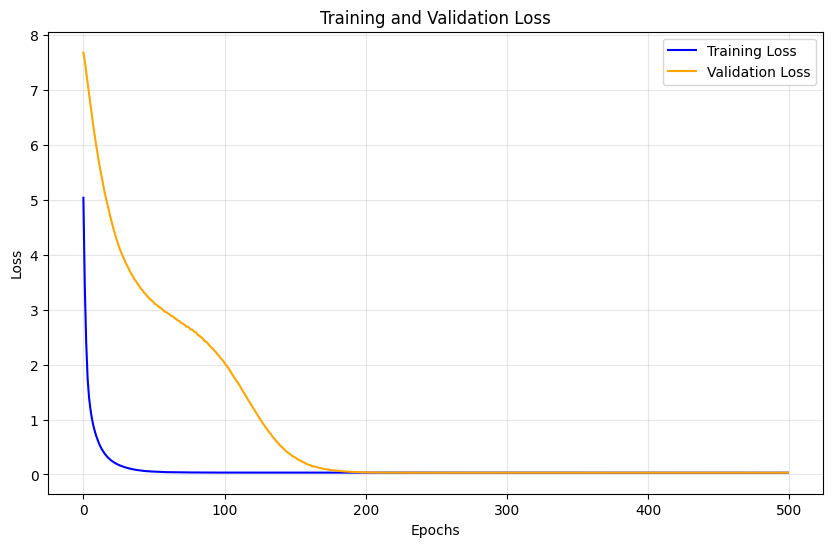

In [4]:
plot_loss(history)

# Prediction & Performance

In [5]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [6]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/sulfate/modified/pm25/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/related_sulfate_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Sulfate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :17], ctrl_data[:,17]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 2s 305ms/step


In [7]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [8]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

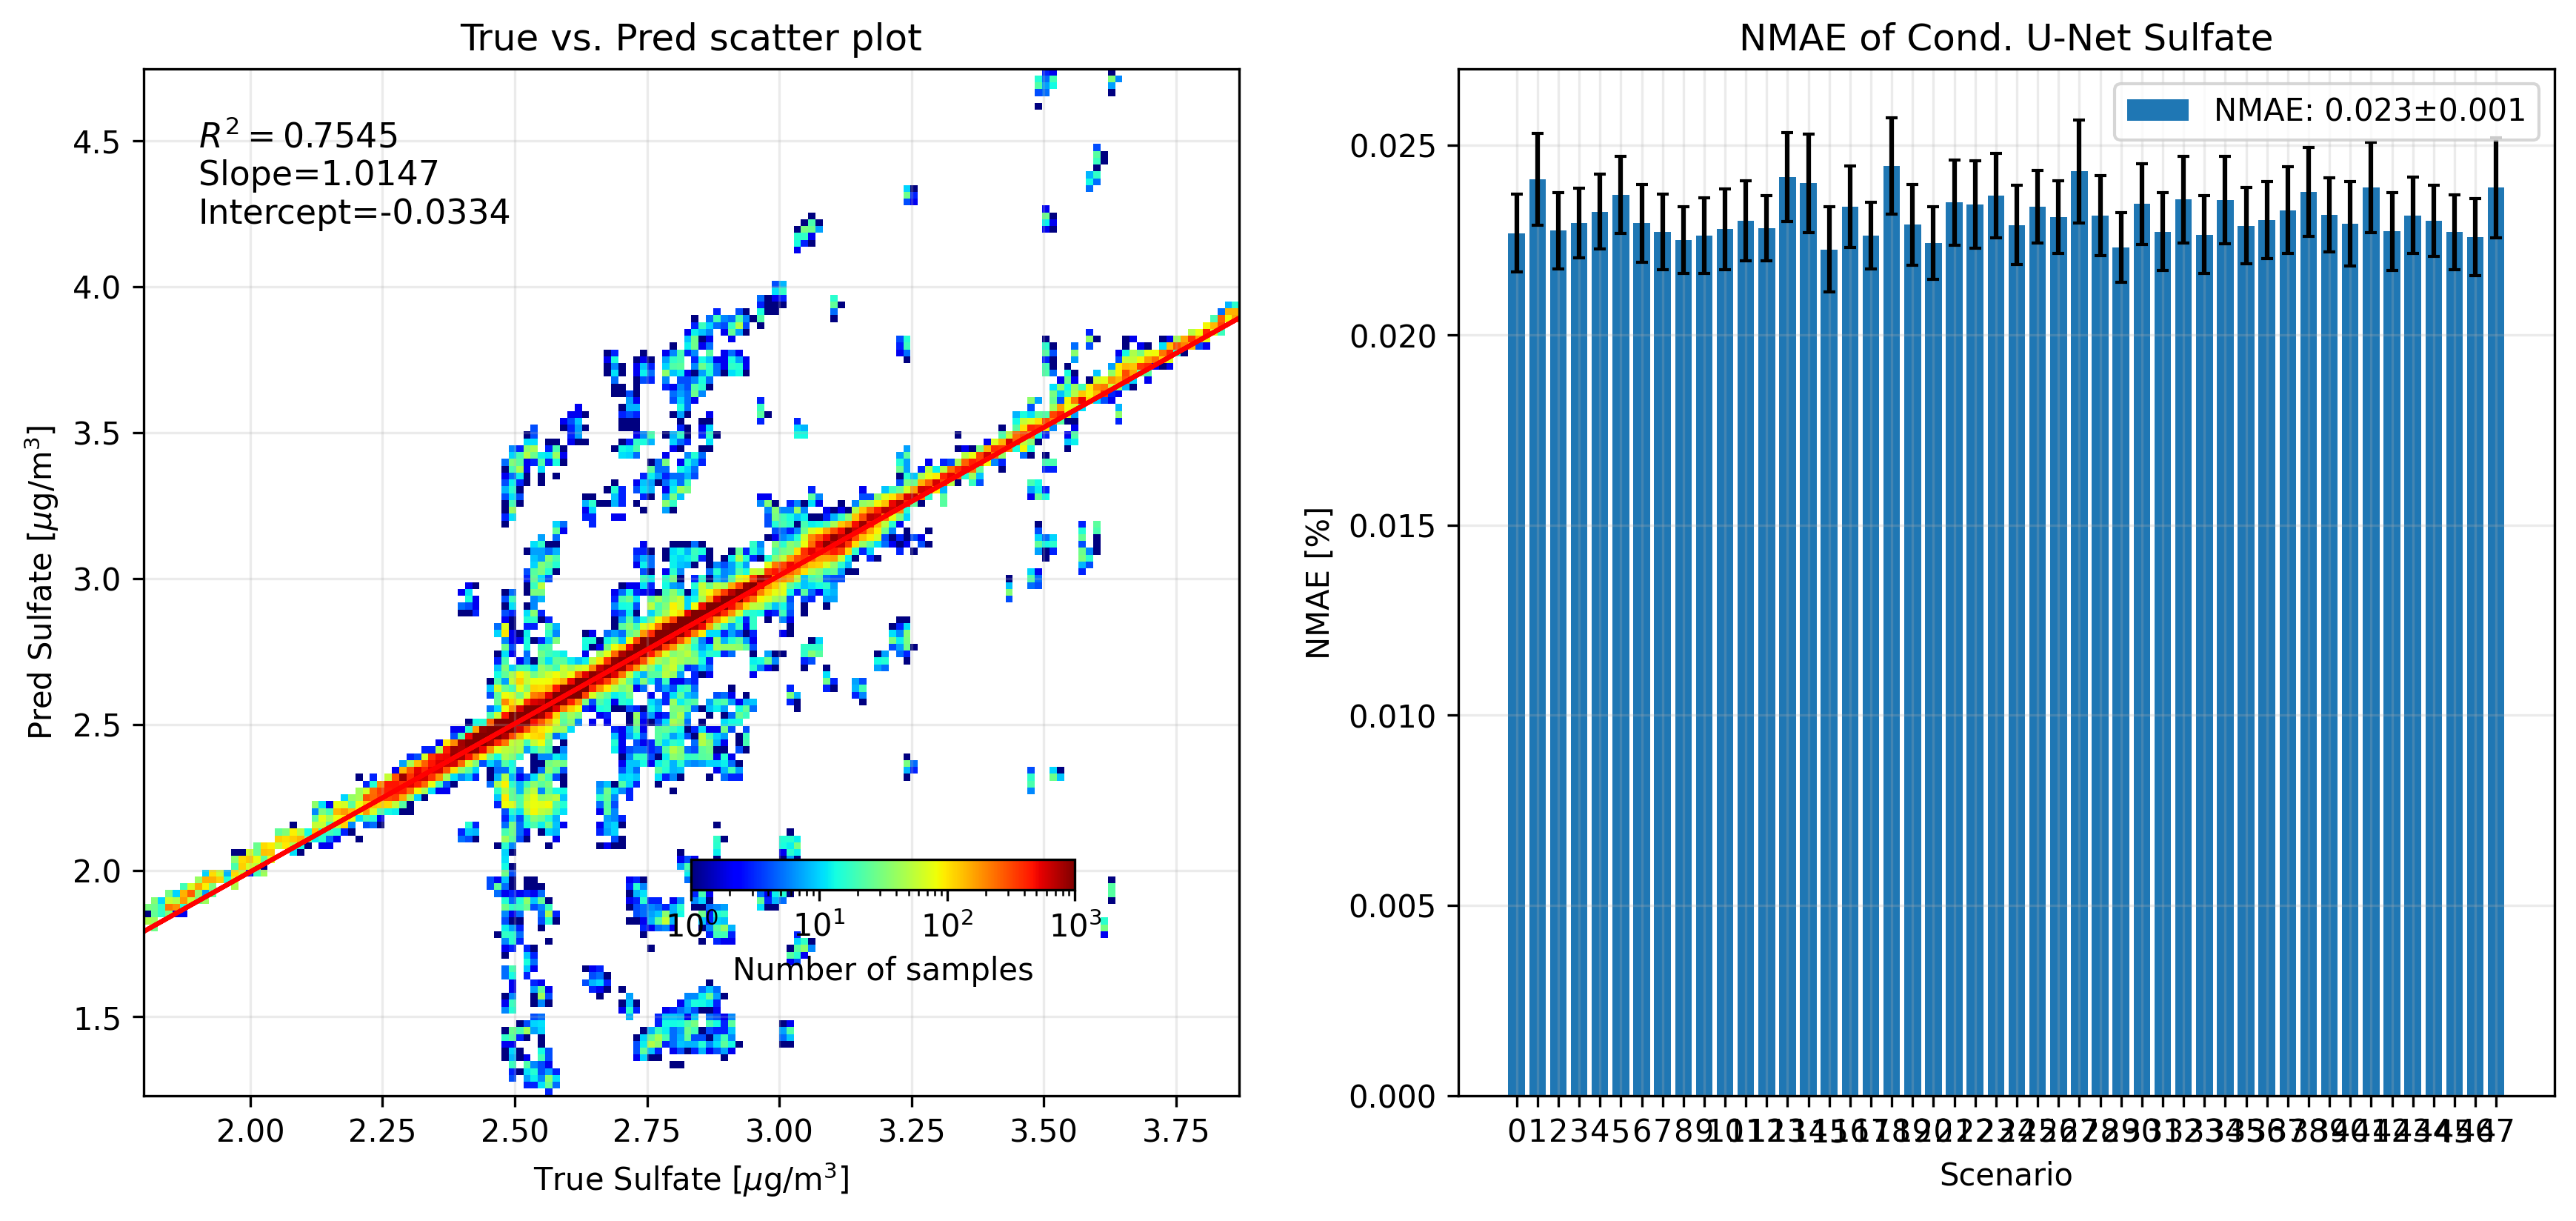

In [9]:
y_pred_ori = y_pred.reshape(-1)
y_true_ori = y_true.reshape(-1)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_ori, y_pred_ori)
axes[0].grid(alpha=0.25)
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Sulfate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Sulfate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_ori = y_test.reshape(y_test.shape[0], -1)
y_pred_ori = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Sulfate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')
plt.show()

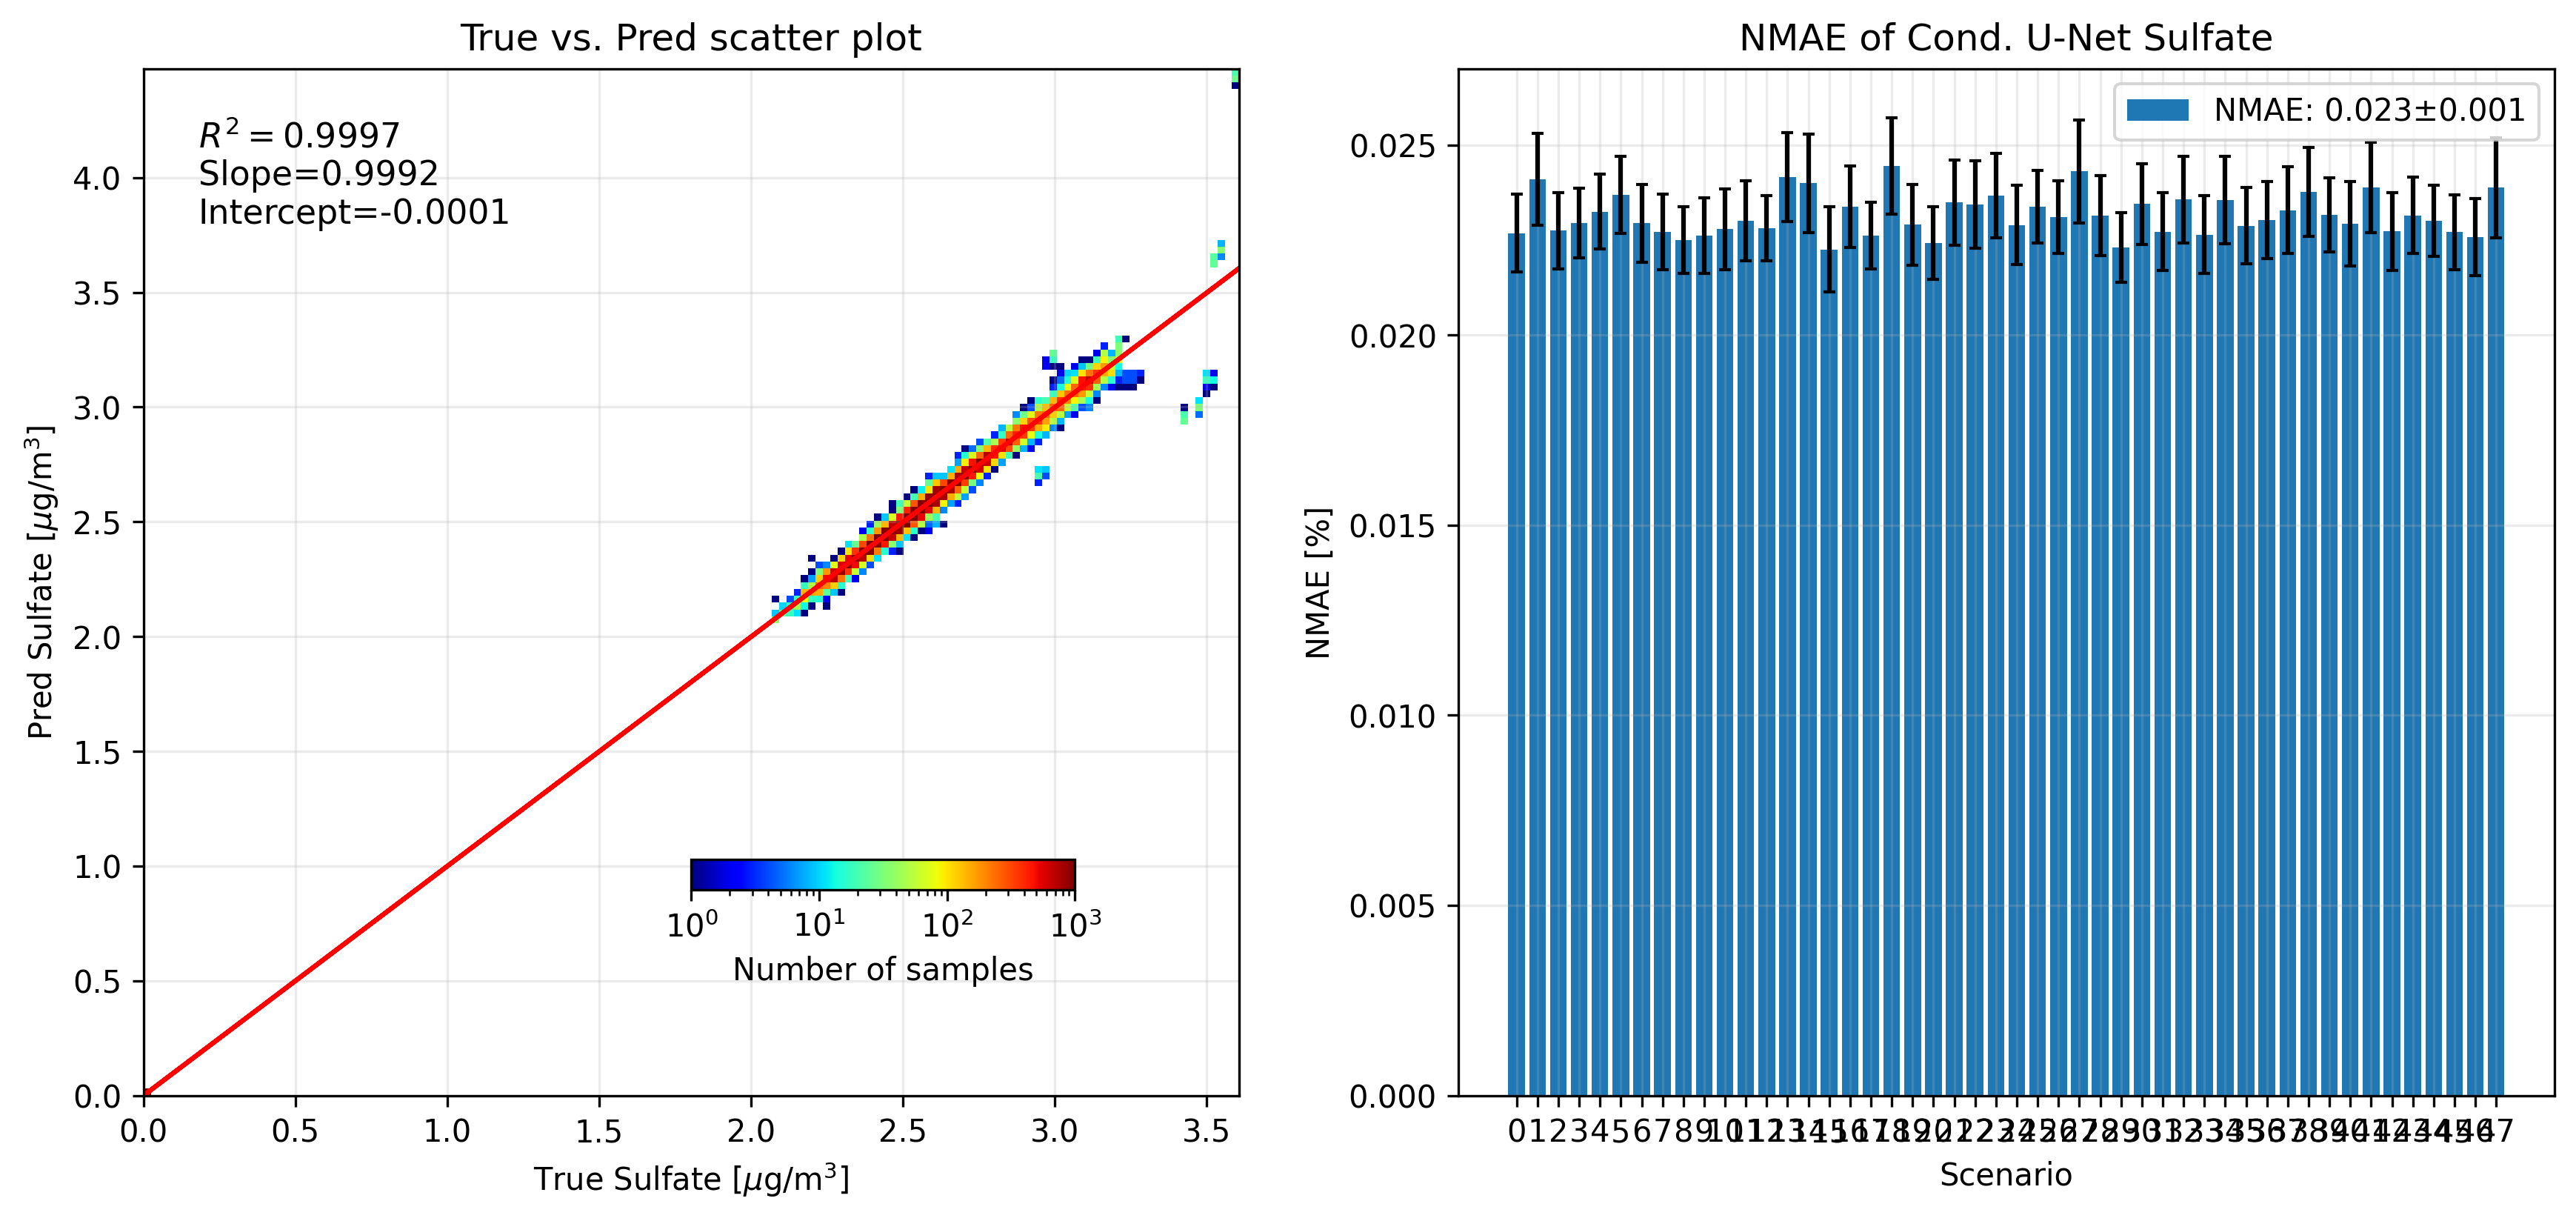

In [10]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_modi, y_pred_modi)
axes[0].grid(alpha=0.25)
# axes[0].set_xlim(3, 67)  # True 축 범위를 조정
# axes[0].set_ylim(3, 69)  # Pred 축 범위를 조정
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Sulfate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Sulfate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_modi = y_test.reshape(y_test.shape[0], -1)
y_pred_modi = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true_modi, y_pred_modi)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Sulfate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')

plt.show()

In [11]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


[24]


/tmp/ipykernel_1462973/3969457850.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462973/3969457850.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462973/3969457850.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462973/3969457850.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462973/3969457850.py:62: UserWarning: set_ti

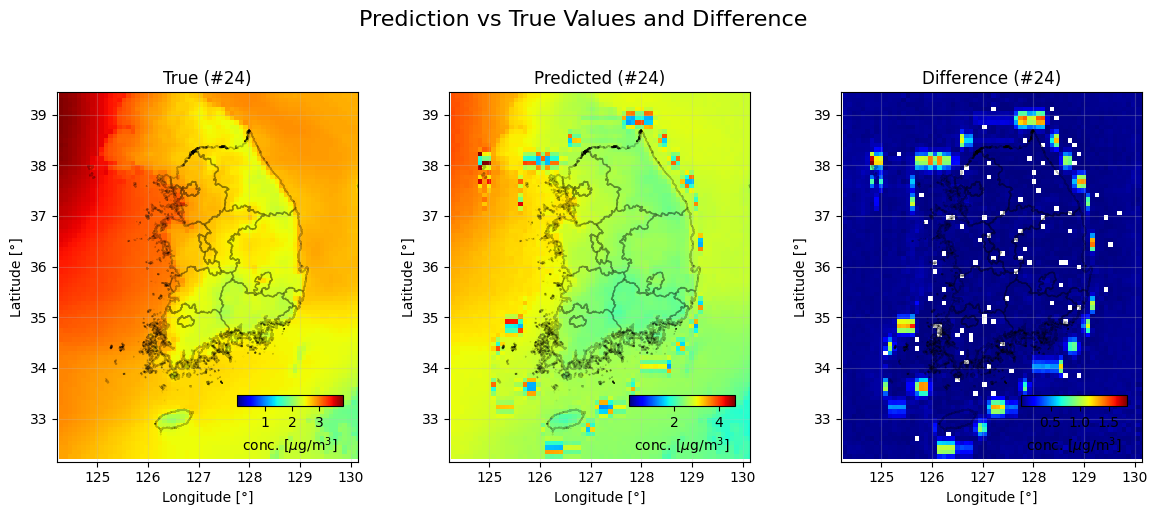

[37]


/tmp/ipykernel_1462973/3969457850.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462973/3969457850.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462973/3969457850.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462973/3969457850.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462973/3969457850.py:62: UserWarning: set_ti

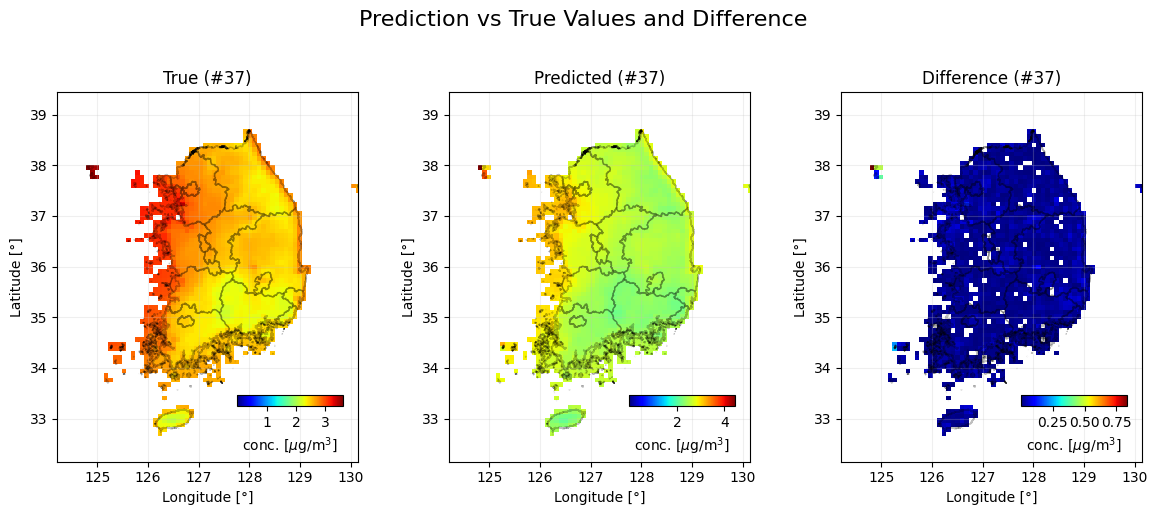

In [12]:
def plot_prediction_loss(y_true, y_pred, num_samples=1):
    indices = np.random.choice(len(y_true), num_samples, replace=False)
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Sulfate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Sulfate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Sulfate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(y_true, y_pred)
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines)

[34]


/tmp/ipykernel_1462973/3969457850.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462973/3969457850.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462973/3969457850.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462973/3969457850.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462973/3969457850.py:62: UserWarning: set_ti

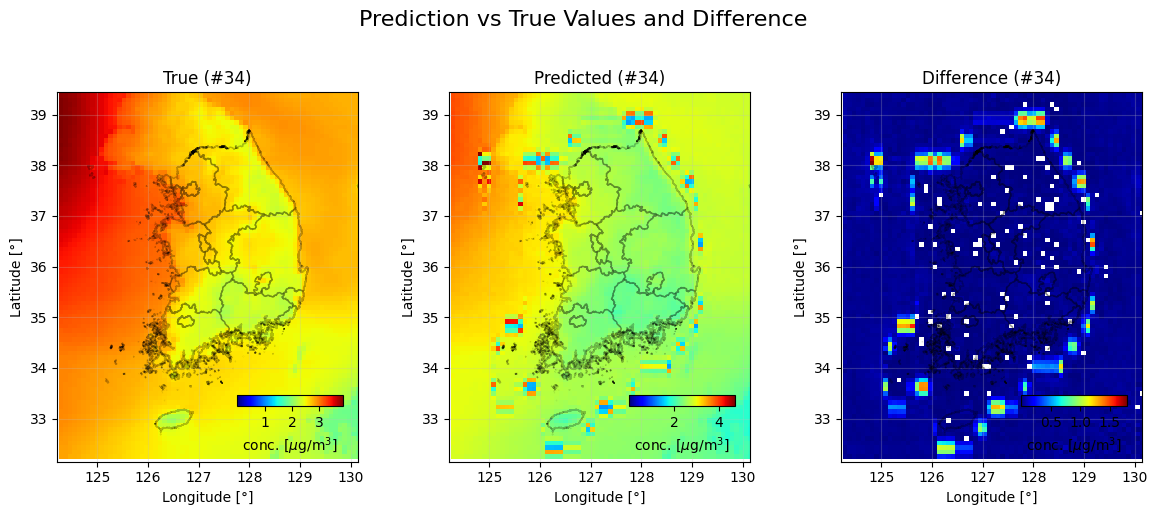

[39]


/tmp/ipykernel_1462973/3969457850.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462973/3969457850.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462973/3969457850.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462973/3969457850.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462973/3969457850.py:62: UserWarning: set_ti

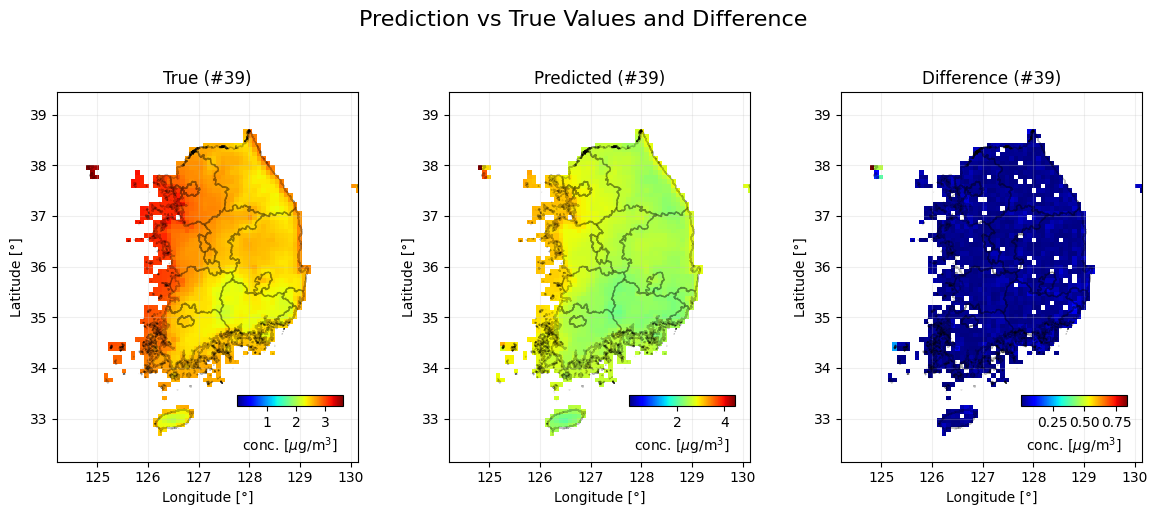

In [13]:
def plot_prediction_loss(y_true, y_pred, num_samples=1):
    indices = np.random.choice(len(y_true), num_samples, replace=False)
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Sulfate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Sulfate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Sulfate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(y_true, y_pred)
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines)

In [14]:
tf.keras.backend.clear_session()

In [16]:
import shap

In [44]:
# 모델 입력 확인
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/sulfate/modified/pm25/final_model')
for i, layer in enumerate(model.input):
    print(f"Input {i}: Shape = {layer.shape}")


Input 0: Shape = (None, 17)
Input 1: Shape = (None, 1)


In [54]:
def custom_predict(X):
    X_emis = X[:, :17]  # 첫 번째 입력 (열 0~16)
    # X_boundary = X[:, 17:]  # 두 번째 입력 (열 17 이상)
    return model.predict([X_emis, [0]])

In [55]:
explainer = shap.KernelExplainer(custom_predict, X_emis_sample)
shap_values = explainer.shap_values(X_emis_sample)

Provided model function fails when applied to the provided data set.


ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'int\'>"})', "<class 'numpy.ndarray'>"}), <class 'NoneType'>